In [70]:
# Required imports
import json
import re
import zipfile as zp
import pandas as pd
import numpy as np
import emoji
import random
import pygal

In [ ]:
# Generating data
import matplotlib

In [ ]:
# Loading data from csv for faster testing
# messages_table = pd.read_csv('przykladowe_dane.csv', index_col=0, parse_dates=['time'])
my_name = 'Jacek Stasiak'

In [38]:

def get_structure(zip):
    folders = {}
    for i in zip.namelist():
        entry = i.split('/')
        last = entry[-1]
        outer = folders
        for j in entry:
            if j != '':
                if j != last and j not in outer:
                    outer[j] = {}
                if j == last:
                    if '__files' not in outer:
                        outer['__files'] = []
                    outer['__files'].append((j, i))
                if j != last:
                    outer = outer[j]
    return folders


def get_messages(folder):
    message_files = []
    for i in folder.keys():
        files = folder[i]['__files']
        for i in files:
            if re.match(r'.+\.json', i[0]):
                message_files.append(i[1])
    return message_files


def analyse_file(file):
    # stats = {}
    # js = json.loads(file)
    # people = {}
    # for i in js['messages']:
    #     sender = i['sender_name'].encode('latin1').decode('utf8')
    #     if sender not in people:
    #         people[sender] = 0
    #     people[sender] += 1
    # stats['message_count'] = people
    # return stats
    js = json.loads(file)
    # js = json.loads(file)

    constants = [js['title'].encode('latin1').decode('utf8'), js['thread_type']] # wartości które są stałe dla danego czatu, ale może są warte zamieszczenia w tabeli.

    entries = []

    for i in js['messages']:
        content = i.get('content')
        if content:
            content = content.encode('latin1').decode('utf8')
        entries.append([i['sender_name'].encode('latin1').decode('utf8'), i['timestamp_ms'], content])

    entries = np.array(entries)

    data = pd.DataFrame({'conversation': constants[0], 'thread_type': constants[1], 'sender': entries[:, 0], 'time': entries[:, 1], 'content': entries[:, 2]})
    data['time'] = pd.to_datetime(data['time'], unit='ms')

    return data

def gen_pandas_table(zip):
    messages_table = None

    folders = get_structure(zip)
    message_files = get_messages(folders['messages']['inbox'])

    for i in message_files:
        temp_file = zip.getinfo(i)
        # with io.TextIOWrapper(zip.open(temp_file), 'utf-8') as f: # Otwieranie pliku jako tekst, żeby można było odrazu zamienić escapowane znaki na właściwe.
        with zip.open(temp_file) as f:
            stats = analyse_file(f.read())
            if messages_table is None:
                messages_table = stats
            else:
                messages_table = pd.concat([messages_table, stats])

    namefile = folders['profile_information']['__files'][0][1]
    username = ""
    with zip.open(namefile) as f:
        data = json.loads(f.read())
        username = data['profile']['name']['full_name'].encode('latin1').decode('utf8')

    return {'table': messages_table, 'username': username}


In [39]:
zip_path = "/home/jacek/Pobrane/Okon_Slowacki_30_11_2020.zip"
data = None
with zp.ZipFile(zip_path) as zip:
    data = gen_pandas_table(zip)

['😅', '😂', '🥱', '🐬', '🤔', '🍍', '😴', '👌', '😪', '🐺', '🦈', '🐟', '🎃', '💜', '🤍', '🍿', '😃', '🙂', '🤣', '😉', '👍', '🌊', '🔥', '😁', '🎼']


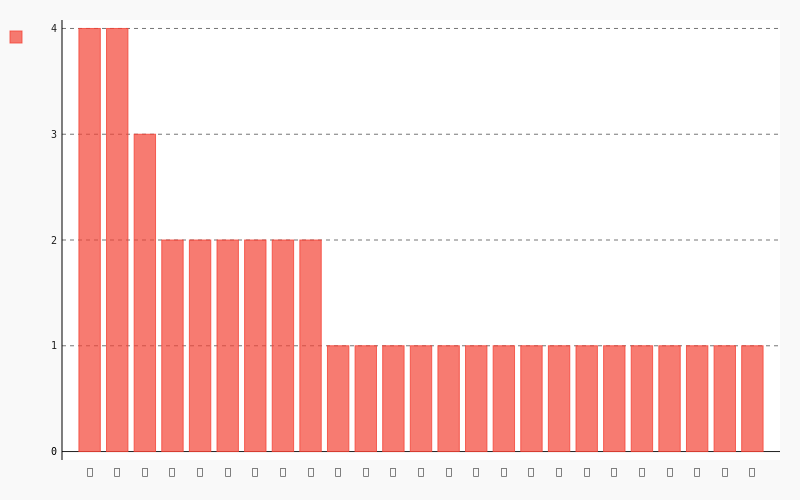

In [84]:
# print(ord(list(emoji.UNICODE_EMOJI.keys())[0]))
# print(ord(list(emoji.UNICODE_EMOJI.keys())[-2]))
def check_emojis(s):
    found = {}
    if s == None:
        return found
#     print(s)
    for i in s:
        if i in emoji.UNICODE_EMOJI:
            if i in found:
                found[i] += 1
            else:
                found[i] = 1
    return found

def emoji_ranking(data):
    table = data['table']
    my_name = data['username']
    msgs = table[table['sender'] == my_name]['content']
    
    all_emojis = {}
    for i in msgs:
        emojis = check_emojis(i)
        for j in emojis:
            if j in all_emojis:
                all_emojis[j] += 1
            else:
                all_emojis[j] = 1
    emoji_v = []
    emoji_l = []
#     all_emojis = [(k, v) for k, v in sorted(all_emojis.items(), key=lambda i: i[1], reverse=True)]
    for k, v in sorted(all_emojis.items(), key=lambda i: i[1], reverse=True):
        emoji_v.append(v)
        emoji_l.append(k)                             
    
    chart = pygal.Bar(height=len(emoji_l)*20)
    chart.add('', emoji_v)
    chart.x_labels =  list(emoji_l)
    print(emoji_l)
#     chart.render_to_file("emoji_wykres.png")
    chart.render_to_png("emoji_wykres.png")
#     print( all_emojis[:])
    return chart
                
a = emoji_ranking(data)
a
# test = '🤔jakis tekst 🤔 🤔 🤔 '
# for i in test:
#     print(i)
    

In [ ]:
# Z kim najczęściej piszę (najwięcej wiadomości których autorem nie jestem ja, w konwersacjach które nie są grupą)

def messages_ranking(data, my_name):

    regs = data[(data['thread_type'] == 'Regular') & (data['sender'] == my_name)]
    group = regs.groupby('conversation')

    counts = group['content'].count().sort_values(ascending=False)
    print(counts)
    # chart = pygal.Bar()
    # chart.add('', counts)
    # chart.x_axis = counts.columns
    # chart.render_to_file("wykres4.svg")

    return None

messages_ranking(messages_table, my_name)

In [ ]:
# Funkcje do analizowania wiadomości

def update_word_freq(words, all_words, num_words, word_stats):
    word_stats[0] += len(words)
    word_stats[1] += 1

    for j in words:
        if j not in all_words:
            all_words[j] = 1
        else:
            all_words[j] += 1
        word_stats[2] += len(j)
        word_stats[3] += 1

# Zwraca 100 najczęstrzych słów, średnią długość zdania, średnią długość słowa
def get_conversation_stats(messages):
    word_frequency = {}

    avg_sentence_len = 0
    n_sentences = 0

    avg_word_len = 0
    n_words = 0

    word_stats = [0] * 4


    for i in messages:
        # print(type(i))
        # if type(i):
        try:
            words = re.findall(r"[\w']+", i)
            words = list(map(lambda a: a.lower(), words))
            update_word_freq(words, word_frequency, num_words, word_stats)
        except Exception:
            pass

    # for i in word_frequency.keys():
    #     print()
    sorted_words = [(k, v) for k, v in sorted(word_frequency.items(), key=lambda i: i[1], reverse=True)]
    # print("100 most common words: ")
    # print(sorted_words[:100])

    # print(word_stats)
    avg_sentence = 0
    avg_word = 0
    try:
        avg_sentence = word_stats[0] / word_stats[1]
        avg_word = word_stats[2] / word_stats[3]
    except Exception:
        pass

    return (sorted_words[:100], avg_sentence, avg_word)
    # print("avg sentence len: {:.2f} words.".format(word_stats[0] / word_stats[1]))
    # print("avg word len: {:.2f} letters.".format(word_stats[2] / word_stats[3]))
    # for


In [ ]:
# Średnia liczba słów, długość słowa i 100 najczęstrzych słów.
msgs = messages_table[:]['content'].dropna().astype("string")
# msg_by_person = messages_table[messages_table['thread_type'] == 'Regular' & messages_table['sender'] != my_name].groupby('sender')
msg_by_person = messages_table.groupby('sender')

stats = {}

for person, messages in msg_by_person:
    stats[person] = get_conversation_stats(messages['content'])
    # if person == 'Hubert Domżałowicz':
    #     print(tstat)
    #     for i in messages['content'][:10]:
            # print(i)

# print(stats)
for k, v in stats.items():
    print(k, v[0][:5], v[1:])
# msg_by_person.get_group('Hubert Domżałowicz')

In [ ]:
# Kto najszybiej odpowiada

tmsg = messages_table[messages_table['conversation'] == 'Krzysztof Pijanowski']
tmsg.head()

In [ ]:
a = pd.Series([1, 2, 2, 2, 3, 4, 5, 1, 1, 1, 2, 1, 2, 2, 1])
a.loc[a.diff() != 0] # Jeżeli jest kilka takich samych wartości to są one usuwane, ale nie wiem czy pierwsza czy ostatnia, a lepiej żeby była ostatnia